#### Load Dataset

In [1]:
# Import required modules
import numpy as np
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from pprint import pprint
from IPython.display import display
import seaborn as sns; sns.set(font_scale=1.2)

import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Load the data into variable 'df'

#df = pd.read_csv(
#    "https://raw.githubusercontent.com/cdmorgan103/7331DataMiningNoShow/master/data/CleanedData.csv" 
    #sep=","
#    ,index_col = 'Unnamed: 0'
#)

# Load the data into variable 'df'
df = pd.read_csv('https://raw.githubusercontent.com/cdmorgan103/7331DataMiningNoShow/master/data/KaggleV2-May-2016.csv')

# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


#### Clean Dataset

In [2]:
# Convert categorical variables to the correct datatype
categ_features = ['Gender', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes',
                  'Alcoholism', 'Handcap', 'SMS_received', 'No-show'
                  ]
df[categ_features] = df[categ_features].astype('category')

# Pull-out the scheduled time of day as a new variable (ScheduledTime) and re-insert into df
df.ScheduledDay, ScheduledTime = df.ScheduledDay.str.split('T', 1).str
df.insert(loc=4, column='ScheduledTime', value=ScheduledTime)

# Convert date-time variables to the correct type using the C-style fmt codes
df.ScheduledDay = pd.to_datetime(df.ScheduledDay, format="%Y-%m-%d")
df.ScheduledTime = pd.to_datetime(df.ScheduledTime, format="%H:%M:%SZ").dt.time
df.AppointmentDay = pd.to_datetime(df.AppointmentDay, format="%Y-%m-%dT%H:%M:%SZ")

# Cast PatientId as int
df.PatientId = df.PatientId.astype(np.int64)

# Rename incorrect column names.
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

# Impute the values of sub zero age observations
df.Age=df.Age.replace(-1, int(df.Age.median()))

# Create a column showing days in advance
df['DaysInAdvance']=(df['AppointmentDay']-df['ScheduledDay']).dt.days

# Run through the data to ensure no appointments that are scheduled after the appointment(which would be impossible).
# If true, scheduled day with the appointment day is assumed as the a same day as the appointment, then recalculate advance field
df['ScheduledDay'] = np.where(df['ScheduledDay']>df['AppointmentDay'], df['AppointmentDay'], df['ScheduledDay'])
df['DaysInAdvance']=(df['AppointmentDay']-df['ScheduledDay']).dt.days

# Create a day of week variable for both the scheduled day and the appointment day which will allows to examining
#  any potential trends related to the day of the week and appointment no-show
df['ScheduledDOW'] = df['ScheduledDay'].dt.weekday_name
df['AppointmentDOW'] = df['AppointmentDay'].dt.weekday_name



#### Create new variables

In [3]:
#new variables
df['age_range'] = pd.cut(df.Age,[0,16,65,1e6],3,labels=['child','adult','senior']) 
df = df.replace({'NoShow': {'Yes': 1, 'No': 0}})

df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 19 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null category
ScheduledDay      110527 non-null datetime64[ns]
ScheduledTime     110527 non-null object
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null category
Scholarship       110527 non-null category
Hypertension      110527 non-null category
Diabetes          110527 non-null category
Alcoholism        110527 non-null category
Handicap          110527 non-null category
SMSReceived       110527 non-null category
NoShow            110527 non-null int64
DaysInAdvance     110527 non-null int64
ScheduledDOW      110527 non-null object
AppointmentDOW    110527 non-null object
age_range         106988 non-null category
dtypes: category(9), datetime64[ns](2), int64(5), object(3)
memory usage: 9.4+ MB

#### Remove ID variables

In [4]:
#Remove attributes not usefull
del df['PatientId']
del df['AppointmentID']

df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 17 columns):
Gender            110527 non-null category
ScheduledDay      110527 non-null datetime64[ns]
ScheduledTime     110527 non-null object
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null category
Scholarship       110527 non-null category
Hypertension      110527 non-null category
Diabetes          110527 non-null category
Alcoholism        110527 non-null category
Handicap          110527 non-null category
SMSReceived       110527 non-null category
NoShow            110527 non-null int64
DaysInAdvance     110527 non-null int64
ScheduledDOW      110527 non-null object
AppointmentDOW    110527 non-null object
age_range         106988 non-null category
dtypes: category(9), datetime64[ns](2), int64(3), object(3)
memory usage: 7.7+ MB


#### List Continuous Variables

In [5]:
df.describe()

,Age,NoShow,DaysInAdvance
count,110527.000000,110527.000000,110527.000000
mean,37.089218,0.201933,10.183792
std,23.109921,0.401444,15.254924
min,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000
50%,37.000000,0.000000,4.000000
75%,55.000000,0.000000,15.000000
max,115.000000,1.000000,179.000000


In [6]:
df.head()

,Gender,ScheduledDay,ScheduledTime,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,DaysInAdvance,ScheduledDOW,AppointmentDOW,age_range
0,F,2016-04-29,18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,Friday,Friday,adult
1,M,2016-04-29,16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0,Friday,Friday,adult
2,F,2016-04-29,16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,0,Friday,Friday,adult
3,F,2016-04-29,17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0,Friday,Friday,child
4,F,2016-04-29,16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0,Friday,Friday,adult


#### Simple scatter plot of Continuous

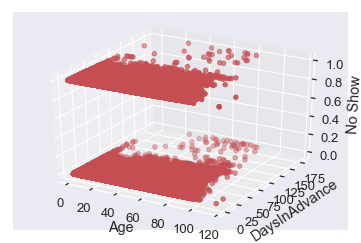

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df['Age']
y = df['DaysInAdvance']
z = df['NoShow']

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Age')
ax.set_ylabel('DaysInAdvance')
ax.set_zlabel('No Show')

plt.show()

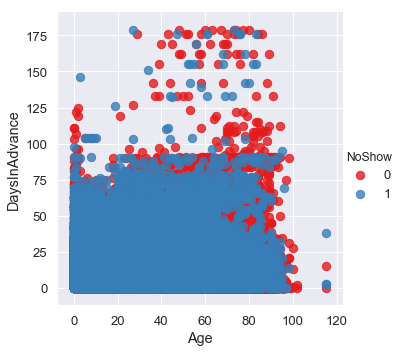

In [8]:
#plot
sns.lmplot('Age','DaysInAdvance', data=df, hue='NoShow', palette='Set1', fit_reg=False, scatter_kws={"s": 70})

In [9]:
# NOTE: calling describe when not all the data is categorical will cause the 
# categorical variables to be removed
df[['ScheduledDay','ScheduledTime','AppointmentDay',
    'Gender','age_range','Neighbourhood','Scholarship',
    'Hypertension','Diabetes','Alcoholism','Handicap',
    'SMSReceived','ScheduledDOW','AppointmentDOW','NoShow']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NoShow,110527.0,0.201933,0.401444,0.0,0.0,0.0,0.0,1.0


#### One Hot Encode Variables

In [10]:
# perform one-hot encoding of the categorical data 
tmp_df = pd.get_dummies(df.Handicap,prefix='Handicap')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.AppointmentDOW,prefix='AppointmentDOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.ScheduledDOW,prefix='ScheduledDOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

#tmp_df = pd.get_dummies(df.Neighbourhood,prefix='Neighbourhood')
#df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.age_range,prefix='age_range')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

In [11]:
# replace the current Gender atribute with something slightly more intuitive and readable
df['IsMale'] = df.Gender=='male' 
df.IsMale = df.IsMale.astype(np.int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 38 columns):
Gender                      110527 non-null category
ScheduledDay                110527 non-null datetime64[ns]
ScheduledTime               110527 non-null object
AppointmentDay              110527 non-null datetime64[ns]
Age                         110527 non-null int64
Neighbourhood               110527 non-null category
Scholarship                 110527 non-null category
Hypertension                110527 non-null category
Diabetes                    110527 non-null category
Alcoholism                  110527 non-null category
Handicap                    110527 non-null category
SMSReceived                 110527 non-null category
NoShow                      110527 non-null int64
DaysInAdvance               110527 non-null int64
ScheduledDOW                110527 non-null object
AppointmentDOW              110527 non-null object
age_range                   106988 non-null 

#### Remove variables

In [12]:
# Now let's clean up the dataset
if 'Gender' in df:
    del df['Gender'] # if 'Sex' column still exists, delete it (as we created an ismale column)
    
if 'Handicap' in df:    
    del df['Handicap'] # get reid of the original category as it is now one-hot encoded
    
if 'ScheduledDOW' in df:    
    del df['ScheduledDOW'] # get reid of the original category as it is now one-hot encoded
    
if 'AppointmentDOW' in df:    
    del df['AppointmentDOW'] # get reid of the original category as it is now one-hot encoded

if 'Neighbourhood' in df:    
    del df['Neighbourhood'] # get reid of the original category as it is now one-hot encoded

#remove categorical variables for logistic regression analysis
if 'age_range' in df:
    del df['age_range']

if 'AppointmentID' in df:
    del df['AppointmentID']
    
if 'ScheduledDay' in df:
    del df['ScheduledDay']
    
if 'ScheduledTime' in df:
    del df['ScheduledTime']

if 'AppointmentDay' in df:
    del df['AppointmentDay']
    
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 29 columns):
Age                         110527 non-null int64
Scholarship                 110527 non-null category
Hypertension                110527 non-null category
Diabetes                    110527 non-null category
Alcoholism                  110527 non-null category
SMSReceived                 110527 non-null category
NoShow                      110527 non-null int64
DaysInAdvance               110527 non-null int64
Handicap_0                  110527 non-null uint8
Handicap_1                  110527 non-null uint8
Handicap_2                  110527 non-null uint8
Handicap_3                  110527 non-null uint8
Handicap_4                  110527 non-null uint8
AppointmentDOW_Friday       110527 non-null uint8
AppointmentDOW_Monday       110527 non-null uint8
AppointmentDOW_Saturday     110527 non-null uint8
AppointmentDOW_Thursday     110527 non-null uint8
AppointmentDOW_Tuesday  

In [13]:
df.head()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMSReceived,NoShow,DaysInAdvance,Handicap_0,Handicap_1,...,ScheduledDOW_Friday,ScheduledDOW_Monday,ScheduledDOW_Saturday,ScheduledDOW_Thursday,ScheduledDOW_Tuesday,ScheduledDOW_Wednesday,age_range_child,age_range_adult,age_range_senior,IsMale
0,62,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
1,56,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,62,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,8,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
4,56,0,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0


#### Creating Numpy Matrices

In [14]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'NoShow' in df:
    y = df['NoShow'].values # get the labels we want
    del df['NoShow'] # get rid of the class label
    X = df.values # use everything else to predict!

In [19]:
## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
#    have converted them into simple matrices to use with scikit learn
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, train_size=0.8)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=0.8)


#### Logistic Regression

In [16]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt


# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
        #NOTE: as you increase C, test diff values by grid search
    #another par is balanced=TRUE/FALSE instead of class weight
    
# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration

#this is the long way (try cross validate function)
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat) #accuracy score function
    conf = mt.confusion_matrix(y_test,y_hat) #true matrix
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.798606713109563
confusion matrix
 [[17578   152]
 [ 4300    76]]
====Iteration 1  ====
accuracy 0.7910069664344522
confusion matrix
 [[17411   154]
 [ 4466    75]]
====Iteration 2  ====
accuracy 0.7980186374739889
confusion matrix
 [[17568   149]
 [ 4316    73]]


### Cross Validation
Cross validation is performed using repeated holdout via ShuffleSplit()

Ten folds are used
The split is: 80% training data and 20% test data
A random seed is set so the same random test and training splits are used each time cross validation is performed.

### Classifier Evaluation
The following functions performs cross validation using cross_validate() for classification estimators and returns accuracy, precision, recall, f1 score, and a confusion matrix for each model.

In [20]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv_object, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y,predictions)
    confMat = confusion_matrix(y,predictions)
    acc = accuracy_score(y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

In [22]:
#Logisitic regression 5-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds = 5
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   45.3s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:  1.8min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=0.8),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [23]:
#Diplay the top model parameters
regGridSearch.best_estimator_

LogisticRegression(C=1, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X, y, cv_object)

The average accuracy for all cv folds is: 			 0.79455
The average precision for all cv folds is: 			 0.3316
The average recall for all cv folds is: 			 0.016966
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.798381,0.379808,0.017926
1,0.791007,0.271111,0.013505
2,0.794264,0.343874,0.019467


In [26]:
EvaluateClassifierEstimator2(classifierEst, X, y, 10)

             precision    recall  f1-score   support

          0       0.80      0.99      0.88     88208
          1       0.29      0.02      0.03     22319

avg / total       0.70      0.79      0.71    110527

[[87315   893]
 [21962   357]]
0.793217946746044


### Start of another model